<a href="https://colab.research.google.com/github/AchiniR/DM-group-project/blob/clustering-1-achini/netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# dataset
#https://www.kaggle.com/datasets/jhajalaj/netflix-india-shows-and-movies/data


# Ref
#https://www.kaggle.com/code/bansodesandeep/netflix-movies-and-tv-shows-clustering/notebook#4.-Cleaning-data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [3]:
# reading data
path = '/content/drive/MyDrive/DM_prroject/netflix_india_shows_and_movies.csv'

original_df = pd.read_csv(path,index_col='showid')
df = original_df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6698 entries, 81607354 to 81023623
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                6698 non-null   object 
 1   type                6698 non-null   object 
 2   rating              6698 non-null   object 
 3   duration            6698 non-null   object 
 4   description         6698 non-null   object 
 5   hook_text           3165 non-null   object 
 6   genre               6698 non-null   object 
 7   release_year        6685 non-null   float64
 8   release_date        6698 non-null   object 
 9   mood_tag            6051 non-null   object 
 10  actors              6031 non-null   object 
 11  creator             1174 non-null   object 
 12  director            4260 non-null   object 
 13  audio               3998 non-null   object 
 14  subtitles           3997 non-null   object 
 15  tags                6698 non-null   object 


In [5]:
df.head()

,name,type,rating,duration,description,hook_text,genre,release_year,release_date,mood_tag,actors,creator,director,audio,subtitles,tags,similar_titles_id,production_country
showid,,,,,,,,,,,,,,,,,,
81607354,A Killer Paradox,TVSeries,A,1 Season,"When one accidental killing leads to another, ...",NaN,Thriller,2024.0,2024-2-9,Offbeat;Suspenseful,Choi Woo-shik;Son Suk-ku;Lee Hee-jun,Lee Chang-hee;Kim Da-min,NaN,NaN,NaN,Korean;Crime TV Shows;K-dramas based on Webtoo...,81444051;81461539;81011211;81640988;80990668;8...,South Korea
81616617,Ashes,Movie,A,1.6667,From an intoxicating fantasy to a dangerous af...,NaN,Drama,2024.0,2024-2-9,Psychological;Intimate;Romantic,Funda Eryiğit;Alperen Duymaz;Mehmet Günsür;Nur...,NaN,Erdem Tepegöz,English;Turkish - Audio Description;Turkish [O...,English;English;Turkish,Turkish;Dramas;Romantic Movies,81732726;81256740;81671215;81637260;81566662;8...,Turkey
81732726,Bhakshak,Movie,A,2.25,A struggling local journalist begins a dogged ...,NaN,Drama,2024.0,2024-2-9,Gritty,Bhumi Pednekar;Sanjay Mishra;Aditya Srivastava...,NaN,Pulkit,English;Hindi - Audio Description;Hindi [Origi...,English;English;Hindi,Hindi-Language Movies;Bollywood Movies;Crime M...,81671215;81637260;81725616;81637261;81740214;8...,India
81611991,"Lover, Stalker, Killer",Movie,U/A 16+,1.5,"In this twisting documentary, a mechanic tries...",NaN,Documentary,2024.0,2024-2-9,NaN,NaN,NaN,Sam Hobkinson,English - Audio Description;English [Original],English,Documentaries;Crime Movies;True Crime Document...,81671836;81130130;81620852;81607097;81212487;8...,NaN
70305903,Interstellar,Movie,U/A 13+,2.8167,With humanity teetering on the brink of extinc...,NaN,Sci-Fi,2014.0,2024-2-9,Mind-Bending;Cerebral,Matthew McConaughey;Anne Hathaway;Jessica Chas...,NaN,Christopher Nolan,English [Original],English;Hindi,Sci-Fi Movies;Dramas;Action & Adventure Movies...,70131314;81198930;80117456;80023689;80244645;8...,United States


In [6]:
# calculating missing values
missing_values = df.isnull()
total_missing_values = missing_values.sum()
print(total_missing_values)

name                     0
type                     0
rating                   0
duration                 0
description              0
hook_text             3533
genre                    0
release_year            13
release_date             0
mood_tag               647
actors                 667
creator               5524
director              2438
audio                 2700
subtitles             2701
tags                     0
similar_titles_id       11
production_country     554
dtype: int64


In [7]:
# convert to date-time
df["release_date"] = pd.to_datetime(df['release_date'])

# create seperate column for year, month, and day
df['month'] = df['release_date'].dt.month
df['year'] = df['release_date'].dt.year
df['day'] = df['release_date'].dt.day

df['day_of_week'] = df['release_date'].dt.dayofweek
df['weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

In [8]:
#Drop columns
df.drop('release_year',axis=1,inplace=True)
df.drop('creator',axis=1,inplace=True)
df.drop('release_date',axis=1,inplace=True)

In [9]:
df[['director','actors','production_country', 'hook_text', 'audio', 'subtitles', 'mood_tag']] = df[['director','actors','production_country', 'hook_text', 'audio', 'subtitles', 'mood_tag']].fillna('Unknown')
df[['similar_titles_id']] = df[['similar_titles_id']].fillna('None')
df['rating'] = df['rating'].fillna(df['rating'].mode()[0])

In [10]:
# Age ratings
df.rating.unique()

array(['A', 'U/A 16+', 'U/A 13+', 'U/A 7+', 'U'], dtype=object)

In [11]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'rating' column
df["rating_encoded"] = label_encoder.fit_transform(df["rating"])

In [12]:
#one hot encoding
dummies=pd.get_dummies(df.type)

df = pd.concat([df,dummies],axis=1)

df.drop('type',axis=1,inplace=True)

In [13]:
df[df['year']==1970]

,name,rating,duration,description,hook_text,genre,mood_tag,actors,director,audio,...,similar_titles_id,production_country,month,year,day,day_of_week,weekend,rating_encoded,Movie,TVSeries
showid,,,,,,,,,,,,,,,,,,,,,
80151644,Puss in Book: Trapped in an Epic Tale,U/A 7+,0.5833,Puss in Boots has fallen into a magic book rul...,Unknown,Kids,Goofy,Eric Bauza;Jayma Mays;Maria Bamford;Jeff Benne...,Roy Burdine;Johnny Castuciano,Unknown,...,80018988;81054409;80994695;81108751;80227574;8...,United States,1,1970,1,3,0,4,1,0
80196044,The Crew,A,1.3333,"After an unexpected misstep, a crew of skilled...",French hip-hop artist Kaaris co-stars as a men...,Thriller,Gritty,Sami Bouajila;Guillaume Gouix;Youssef Hajdi;Re...,Julien Leclercq,Unknown,...,81175433;81079723;81446739;81721676;81115400;7...,France,1,1970,1,3,0,0,1,0
81031181,Goyo: The Boy General,A,2.4833,"Brash ladies' man Gregorio ""Goyo"" del Pilar ri...",Unknown,Drama,Unknown,Paulo Avelino;Carlo Aquino;Arron Villaflor;Mon...,Jerrold Tarog,Unknown,...,81726434;80141777;80218962;81687835;81268316;8...,Philippines,1,1970,1,3,0,0,1,0
81023623,Close Enemies,A,1.8333,"After an ambush leaves his partner dead, drug ...",Nominated for a Golden Lion at the Venice Film...,Drama,Gritty,Matthias Schoenaerts;Reda Kateb;Adel Bencherif...,David Oelhoffen,Unknown,...,81115400;81483371;81102814;81312798;81218770;8...,France,1,1970,1,3,0,0,1,0


In [14]:
## droping the 1970 movies as all the other movies are from 2015 to present
df.drop(df[df['year']==1970].index, axis=0,inplace=True)

In [15]:
df.genre.value_counts()

Drama               1737
Comedy              1357
Documentary          791
Kids                 642
Action               466
Thriller             356
Romance              355
Anime                287
Reality TV           259
Horror               223
Sci-Fi                85
Fantasy               65
Music                 26
Special Interest      10
Talk Show             10
Variety TV             9
Musical                7
Sports                 4
Western                4
Friendship             1
Name: genre, dtype: int64

In [16]:
# Fit and transform the 'genre' column
df["genre_encoded"] = label_encoder.fit_transform(df["genre"])

In [17]:
df.production_country.value_counts()

United States           1898
India                    866
Unknown                  554
Japan                    477
South Korea              402
United Kingdom           265
Spain                    203
Mexico                   148
Africa                   146
France                   125
China                    122
Canada                   111
Brazil                   101
Germany                   86
Indonesia                 83
Turkey                    78
Italy                     76
South Africa              76
Taiwan                    74
Poland                    69
Egypt                     68
Australia                 67
Thailand                  64
Philippines               59
Colombia                  47
Argentina                 44
Scandinavia               37
Malaysia                  34
Singapore                 27
Middle East               25
Saudi Arabia              24
Norway                    23
Netherlands               22
Vietnam                   21
Lebanon       

In [18]:
# Split tags with multiple values
tags_split = [tag.split(';') for tag in df['mood_tag'].values]

# Use MultiLabelBinarizer for one-hot encoding
mlb = MultiLabelBinarizer()
encoded_tags = pd.DataFrame(mlb.fit_transform(tags_split), columns=mlb.classes_)

In [19]:
encoded_tags.columns

Index(['Absurd', 'Adrenaline Rush', 'Bittersweet', 'Campy', 'Cerebral',
       'Charming', 'Chilling', 'Controversial', 'Dark', 'Deadpan', 'Emotional',
       'Exciting', 'Feel-Good', 'Goofy', 'Gritty', 'Heartfelt', 'Inspiring',
       'Intimate', 'Investigative', 'Mind-Bending', 'Nostalgic', 'Offbeat',
       'Ominous', 'Provocative', 'Psychological', 'Quirky', 'Raunchy',
       'Relaxing', 'Romantic', 'Scandalous', 'Scary', 'Sentimental', 'Steamy',
       'Suspenseful', 'Swoonworthy', 'Understated', 'Unknown', 'Violent',
       'Witty'],
      dtype='object')

In [20]:
#dropping unknown tags column
encoded_tags.drop('Unknown',axis=1,inplace=True)

In [21]:
encoded_tags['showid'] = df.index

In [22]:
tags_final = encoded_tags.set_index('showid')

In [23]:
df.director.value_counts()

Unknown                  2438
Raúl Campos;Jan Suter      17
Suhas Kadav                17
Rajiv Chilaka              16
Marcus Raboy               15
                         ... 
Choi Jin-seong              1
Ridha Behi                  1
Assad Fouladkar             1
Ismail Farouk               1
Rhys Thomas                 1
Name: director, Length: 3094, dtype: int64

In [24]:
# Split tags with multiple values
directors_split = [tag.split(';') for tag in df['director'].values]

# Use MultiLabelBinarizer for one-hot encoding
encoded_directors = pd.DataFrame(mlb.fit_transform(directors_split), columns=mlb.classes_)

In [25]:
column_sums = encoded_directors.sum(axis=0)

# Print the column sums
greater_than_10_columns = column_sums[column_sums >=10].index

In [26]:
selected_directors = encoded_directors[greater_than_10_columns]
#dropping unknown directors column
selected_directors.drop('Unknown',axis=1,inplace=True)

In [27]:
selected_directors['showid'] = df.index

In [28]:
directors_final = selected_directors.set_index('showid')

In [29]:
# Extract numerical part from 'duration' column
df['duration'] = df['duration'].str.extract('(\d+\.?\d*)').astype(float)

In [30]:
selected_columns = ['description','month','year','day', 'day_of_week','weekend','rating_encoded','Movie','TVSeries','genre_encoded', 'duration' ]

# Create a new DataFrame with only the selected columns
df_trans = df[selected_columns].copy()

In [31]:
df_trans_new = pd.merge(df_trans, tags_final, left_index=True, right_index=True)
df_trans_new = pd.merge(df_trans_new, directors_final, left_index=True, right_index=True)

In [32]:
# df_trans = pd.concat([df_trans, encoded_tags,selected_directors ])

In [33]:
df_trans_new.head()

,description,month,year,day,day_of_week,weekend,rating_encoded,Movie,TVSeries,genre_encoded,...,Anurag Kashyap,Hayao Miyazaki,Jan Suter,Jay Karas,Kunle Afolayan,Marcus Raboy,Rajiv Chilaka,Raúl Campos,Ryan Polito,Suhas Kadav
showid,,,,,,,,,,,,,,,,,,,,,
81607354,"When one accidental killing leads to another, ...",2,2024,9,4,0,0,0,1,17,...,0,0,0,0,0,0,0,0,0,0
81616617,From an intoxicating fantasy to a dangerous af...,2,2024,9,4,0,0,1,0,4,...,0,0,0,0,0,0,0,0,0,0
81732726,A struggling local journalist begins a dogged ...,2,2024,9,4,0,0,1,0,4,...,0,0,0,0,0,0,0,0,0,0
81611991,"In this twisting documentary, a mechanic tries...",2,2024,9,4,0,3,1,0,3,...,0,0,0,0,0,0,0,0,0,0
70305903,With humanity teetering on the brink of extinc...,2,2024,9,4,0,2,1,0,13,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_trans_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 81607354 to 80058424
Data columns (total 59 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   description      6694 non-null   object 
 1   month            6694 non-null   int64  
 2   year             6694 non-null   int64  
 3   day              6694 non-null   int64  
 4   day_of_week      6694 non-null   int64  
 5   weekend          6694 non-null   int64  
 6   rating_encoded   6694 non-null   int64  
 7   Movie            6694 non-null   uint8  
 8   TVSeries         6694 non-null   uint8  
 9   genre_encoded    6694 non-null   int64  
 10  duration         6694 non-null   float64
 11  Absurd           6694 non-null   int64  
 12  Adrenaline Rush  6694 non-null   int64  
 13  Bittersweet      6694 non-null   int64  
 14  Campy            6694 non-null   int64  
 15  Cerebral         6694 non-null   int64  
 16  Charming         6694 non-null   int64  
 17  Chi

In [35]:
df_trans_new.isnull().sum()

description        0
month              0
year               0
day                0
day_of_week        0
weekend            0
rating_encoded     0
Movie              0
TVSeries           0
genre_encoded      0
duration           0
Absurd             0
Adrenaline Rush    0
Bittersweet        0
Campy              0
Cerebral           0
Charming           0
Chilling           0
Controversial      0
Dark               0
Deadpan            0
Emotional          0
Exciting           0
Feel-Good          0
Goofy              0
Gritty             0
Heartfelt          0
Inspiring          0
Intimate           0
Investigative      0
Mind-Bending       0
Nostalgic          0
Offbeat            0
Ominous            0
Provocative        0
Psychological      0
Quirky             0
Raunchy            0
Relaxing           0
Romantic           0
Scandalous         0
Scary              0
Sentimental        0
Steamy             0
Suspenseful        0
Swoonworthy        0
Understated        0
Violent      

In [36]:
# settings that you use for count vectorizer will go here
tfidf_vectorizer=TfidfVectorizer(use_idf=True)

# just send in all your docs here
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(df_trans_new['description'])

# get the first vector out (for the first document)
print(tfidf_vectorizer_vectors)
print(f'shape of the tfidf_vectorizer_vectors : {tfidf_vectorizer_vectors.shape}')
print(f'datatype : {type(tfidf_vectorizer_vectors)}')


  (0, 3951)	0.20243210384450605
  (0, 13053)	0.3145783880353701
  (0, 15944)	0.09237784068622638
  (0, 2583)	0.25439887292508984
  (0, 9473)	0.27507732434828425
  (0, 725)	0.05848163622580701
  (0, 2432)	0.2410361830968478
  (0, 4762)	0.3075836720206278
  (0, 7137)	0.07035688969263815
  (0, 13889)	0.2676285826446168
  (0, 6726)	0.19669536029804263
  (0, 5452)	0.16719644757912921
  (0, 8727)	0.14833017606437654
  (0, 16136)	0.13647146724995934
  (0, 10177)	0.25132805662079427
  (0, 703)	0.19544441328014894
  (0, 798)	0.2122509168376817
  (0, 14658)	0.06062158018272032
  (0, 8232)	0.20243210384450605
  (0, 7966)	0.23676904242058322
  (0, 285)	0.29654682901249796
  (0, 10097)	0.15840577918618978
  (0, 15834)	0.10492749586591203
  (1, 9923)	0.24706329986895542
  (1, 15272)	0.3396471419681042
  :	:
  (6692, 725)	0.05195088048840901
  (6693, 2829)	0.2933874855404865
  (6693, 1947)	0.2933874855404865
  (6693, 13333)	0.2580298516769126
  (6693, 13278)	0.2530686807949075
  (6693, 12930)	0.23572

In [37]:
vector = pd.DataFrame(tfidf_vectorizer_vectors.toarray())

In [38]:
# vector['showid'] = df_trans_new.index
# vector = vector.set_index('showid')

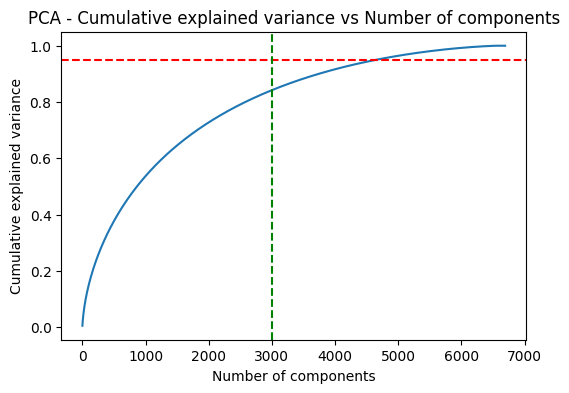

In [39]:
pca = PCA()
pca.fit(vector)

plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('PCA - Cumulative explained variance vs Number of components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y= 0.95, color='red', linestyle='--')
plt.axvline(x= 3000, color='green', linestyle='--')
plt.show()

In [40]:
pca = PCA(n_components=4500)
pca.fit(vector)
X_description = pca.transform(vector)
X_description.shape

(6694, 4500)

In [41]:
X_description_df = pd.DataFrame(X_description)

In [42]:
X_description_df['showid'] = df.index
X_description_df_final = X_description_df.set_index('showid')

In [43]:
df_trans_new.drop('description',axis=1,inplace=True)

In [44]:
X = pd.merge(df_trans_new, X_description_df_final, left_index=True, right_index=True)

In [45]:
X.columns

Index([         'month',           'year',            'day',    'day_of_week',
              'weekend', 'rating_encoded',          'Movie',       'TVSeries',
        'genre_encoded',       'duration',
       ...
                   4490,             4491,             4492,             4493,
                   4494,             4495,             4496,             4497,
                   4498,             4499],
      dtype='object', length=4558)

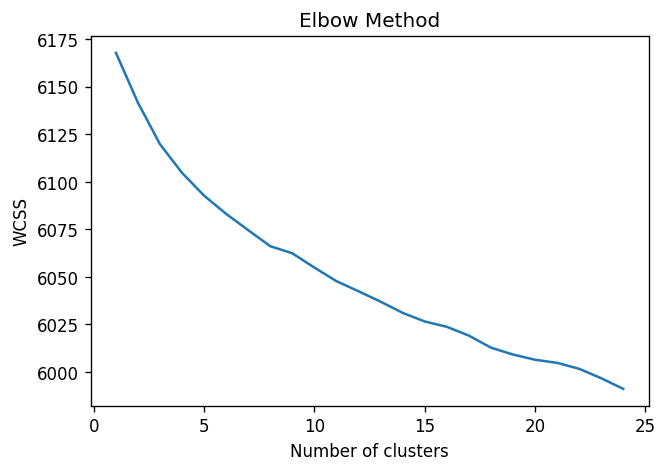

In [46]:
plt.figure(figsize=(6,4), dpi=120)
wcss = []
for i in range(1, 25):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_description_df_final)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 25), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Optimal number of clusters (k): 27


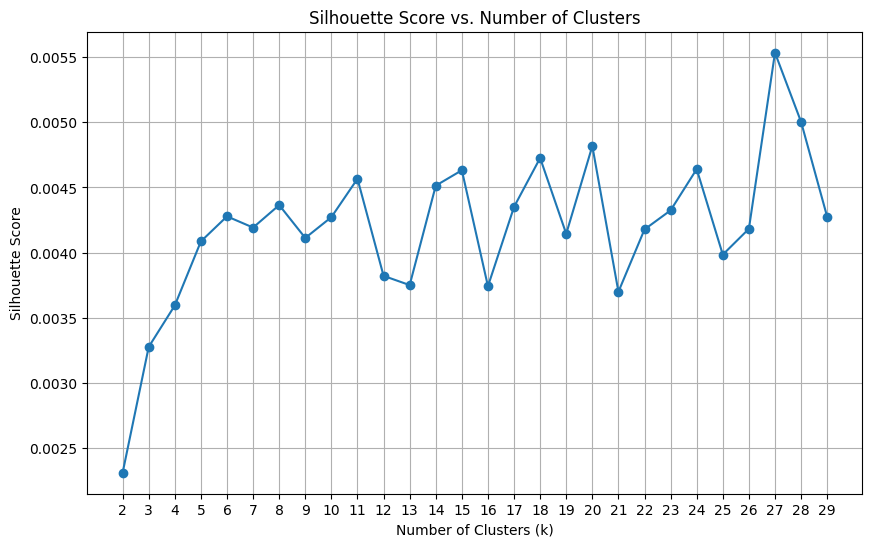

In [47]:
from sklearn.metrics import silhouette_score

k_values = range(2, 30)
silhouette_scores = []

# Iterate over each value of k
for k in k_values:
    # Initialize k-means clustering with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_description_df_final)
    score = silhouette_score(X_description_df_final, kmeans.labels_)
    silhouette_scores.append(score)

# Find the optimal k that maximizes the silhouette score
optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
print("Optimal number of clusters (k):", optimal_k)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)
plt.show()